In [2]:
!pip install torch torchvision fvcore torchinfo --quiet


In [13]:
!pip install matplotlib --quiet

In [3]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import vgg16
from torch.profiler import profile, record_function, ProfilerActivity
from fvcore.nn import FlopCountAnalysis, parameter_count

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
    state_dict = torch.load("vgg16.pth", weights_only=True)
    vgg16 = models.vgg16(pretrained=False).to(device)
    vgg16.load_state_dict(state_dict)

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
input_tensor = torch.randn(1, 3, 224, 224).to(device)

In [8]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with record_function("vgg16_inference"):
        output = vgg16(input_tensor)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

flops = FlopCountAnalysis(vgg16, input_tensor)
params = parameter_count(vgg16)

print(f"FLOPs (Original VGG16): {flops.total()}")
print(f"Parameters (Original VGG16): {params['']}")

Unsupported operator aten::max_pool2d encountered 5 time(s)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        38.43%      52.765ms        84.38%     115.845ms       8.911ms       1.315ms         1.49%       1.315ms     101.167us           0 b           0 b      52.84 Mb      52.84 M

In [9]:
checkpoint = torch.load('vgg16_ht2.pth')
model = checkpoint["model"] 
model.load_state_dict(checkpoint["state_dict"]) 
model = model.to(device)
model.eval()

/tmp/ipykernel_78/3063968472.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('vgg16_ht2.pth')


VGG(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Conv2d(27, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 13, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(13, 19, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (2): Conv2d(19, 19, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
      (3): Conv2d(19, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Conv2d(64, 18, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(18, 31, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (2): Conv2d(31, 34, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
      (3): Conv2d(34, 128, kernel_size=(1,

In [10]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with record_function("vgg16_inference"):
        output = model(input_tensor)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

flops = FlopCountAnalysis(model, input_tensor)
params = parameter_count(model)

print(f"FLOPs (Decomposed VGG16): {flops.total()}")
print(f"Parameters (Decomposed VGG16): {params['']}")

Unsupported operator aten::max_pool2d encountered 5 time(s)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        29.87%      47.605ms        95.12%     151.617ms       3.032ms       1.395ms         0.94%       1.474ms      29.473us           0 b           0 b      99.12 Mb      92.19 M

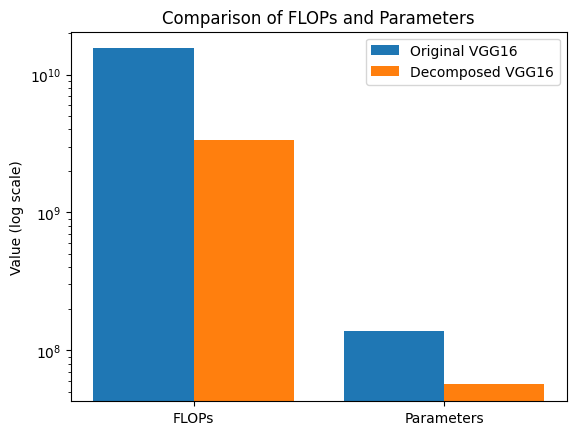

In [17]:
import matplotlib.pyplot as plt

# Metrics
labels = ['FLOPs', 'Parameters']
original_values = [15470289408, 138357544]
decomposed_values = [3380178636, 56395192]

# Bar chart
x = range(len(labels))
plt.bar(x, original_values, width=0.4, label='Original VGG16', align='center')
plt.bar([p + 0.4 for p in x], decomposed_values, width=0.4, label='Decomposed VGG16', align='center')

# Formatting
plt.xticks([p + 0.2 for p in x], labels)
plt.yscale('log')  # Use log scale for clarity
plt.ylabel('Value (log scale)')
plt.title('Comparison of FLOPs and Parameters')
plt.legend()
plt.show()


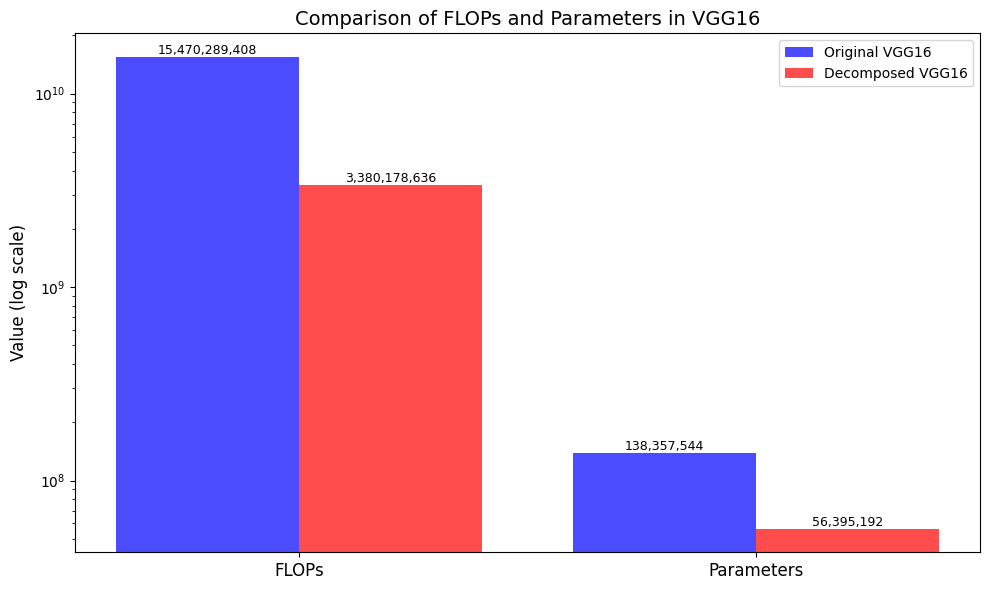

In [18]:
import matplotlib.pyplot as plt

# Metrics
labels = ['FLOPs', 'Parameters']
original_values = [15470289408, 138357544]
decomposed_values = [3380178636, 56395192]

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Bar chart
x = range(len(labels))
plt.bar(x, original_values, width=0.4, label='Original VGG16', align='center', color='blue', alpha=0.7)
plt.bar([p + 0.4 for p in x], decomposed_values, width=0.4, label='Decomposed VGG16', align='center', color='red', alpha=0.7)

# Formatting
plt.xticks([p + 0.2 for p in x], labels, fontsize=12)
plt.yscale('log')  # Use log scale for clarity
plt.ylabel('Value (log scale)', fontsize=12)
plt.title('Comparison of FLOPs and Parameters in VGG16', fontsize=14)
plt.legend(fontsize=10)

# Add value labels on top of each bar
for i, (orig, decomp) in enumerate(zip(original_values, decomposed_values)):
    plt.text(i, orig, f'{orig:,}', ha='center', va='bottom', fontsize=9)
    plt.text(i+0.4, decomp, f'{decomp:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [27]:
state_dict2 = torch.load("resnet50.pth", weights_only=True)
net2 = models.resnet50(pretrained=False).to(device)
net2.fc = torch.nn.Linear(net2.fc.in_features, 10)
net2.load_state_dict(state_dict2)
net2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with record_function("resnet50_inference"):
        output = net2(input_tensor)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

flops2 = FlopCountAnalysis(net2, input_tensor)
params2 = parameter_count(net2)

print(f"FLOPs (Original Resnet-50): {flops2.total()}")
print(f"Parameters (Original Resnet-50): {params2['']}")

Unsupported operator aten::add_ encountered 69 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        24.78%       6.560ms        24.78%       6.560ms      26.033us       0.000us         0.00%       0.000us       0.000us           0 b           0 b           0 b           0 

In [31]:
checkpoint = torch.load('resnet50_ht2.pth')
model2 = checkpoint["model"] 
model2.load_state_dict(checkpoint["state_dict"]) 
model2 = model2.to(device)

/tmp/ipykernel_78/4275405916.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet50_ht2.pth')


In [32]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with record_function("resnet50_inference"):
        output = model2(input_tensor)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

flops = FlopCountAnalysis(model2, input_tensor)
params = parameter_count(model2)

print(f"FLOPs (Decomposed Resnet50): {flops.total()}")
print(f"Parameters (Decomposed resnet50): {params['']}")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        63.34%      74.613ms        83.60%      98.475ms     713.589us       1.817ms         1.55%       2.137ms      15.484us           0 b           0 b      67.20 Mb      27.44 M

Unsupported operator aten::add_ encountered 69 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


FLOPs (Decomposed Resnet50): 3479584227
Parameters (Decomposed resnet50): 18695156


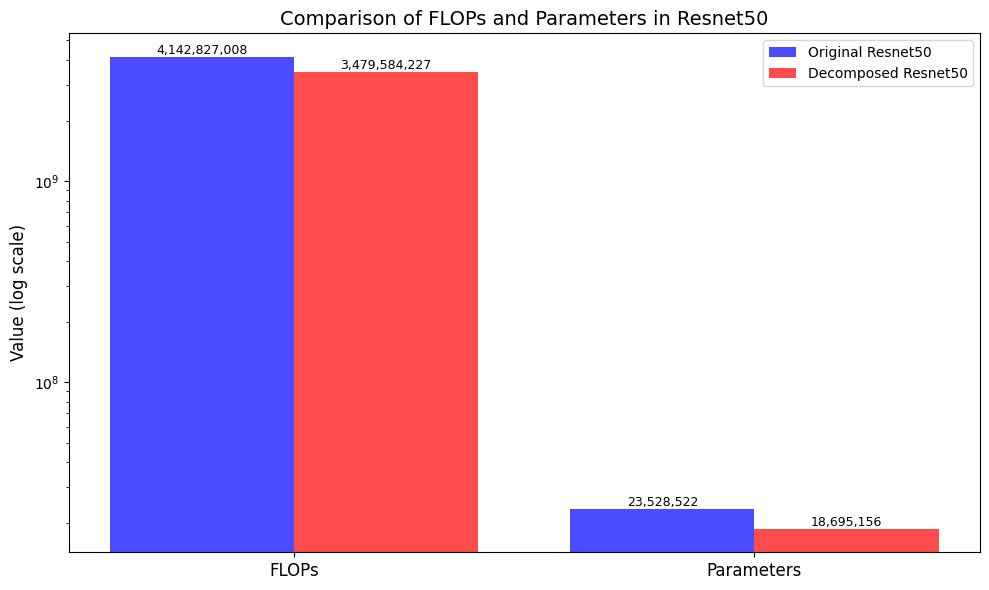

In [34]:
import matplotlib.pyplot as plt

# Metrics
labels = ['FLOPs', 'Parameters']
original_values = [4142827008, 23528522]
decomposed_values = [3479584227, 18695156]

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Bar chart
x = range(len(labels))
plt.bar(x, original_values, width=0.4, label='Original Resnet50', align='center', color='blue', alpha=0.7)
plt.bar([p + 0.4 for p in x], decomposed_values, width=0.4, label='Decomposed Resnet50', align='center', color='red', alpha=0.7)

# Formatting
plt.xticks([p + 0.2 for p in x], labels, fontsize=12)
plt.yscale('log')  # Use log scale for clarity
plt.ylabel('Value (log scale)', fontsize=12)
plt.title('Comparison of FLOPs and Parameters in Resnet50', fontsize=14)
plt.legend(fontsize=10)

# Add value labels on top of each bar
for i, (orig, decomp) in enumerate(zip(original_values, decomposed_values)):
    plt.text(i, orig, f'{orig:,}', ha='center', va='bottom', fontsize=9)
    plt.text(i+0.4, decomp, f'{decomp:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [50]:
net3 = models.alexnet(pretrained=True)
net3.to(device)
net3.eval()

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [51]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with record_function("alexnet_inference"):
        output = net3(input_tensor)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

flops3 = FlopCountAnalysis(net3, input_tensor)
params3 = parameter_count(net3)

print(f"FLOPs (Original AlexNet): {flops3.total()}")
print(f"Parameters (Original AlexNet): {params3['']}")

Unsupported operator aten::max_pool2d encountered 3 time(s)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        47.40%       2.416ms        47.40%       2.416ms      80.542us       0.000us         0.00%       0.000us       0.000us           0 b           0 b           0 b           0 

In [52]:
checkpoint = torch.load('alexnet_ht2.pth')
model3 = checkpoint["model"] 
model3.load_state_dict(checkpoint["state_dict"]) 
model3 = model.to(device)

/tmp/ipykernel_78/2768627348.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('alexnet_ht2.pth')


In [53]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with record_function("alexnet_inference"):
        output = model3(input_tensor)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

flops4 = FlopCountAnalysis(model3, input_tensor)
params4 = parameter_count(model3)

print(f"FLOPs (Decomposed AlexNet): {flops4.total()}")
print(f"Parameters (Decomposed AlexNet): {params4['']}")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        48.07%      18.337ms        48.07%      18.337ms      40.659us       0.000us         0.00%       0.000us       0.000us           0 b           0 b           0 b           0 

Unsupported operator aten::add_ encountered 69 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


FLOPs (Decomposed AlexNet): 3479584227
Parameters (Decomposed AlexNet): 18695156


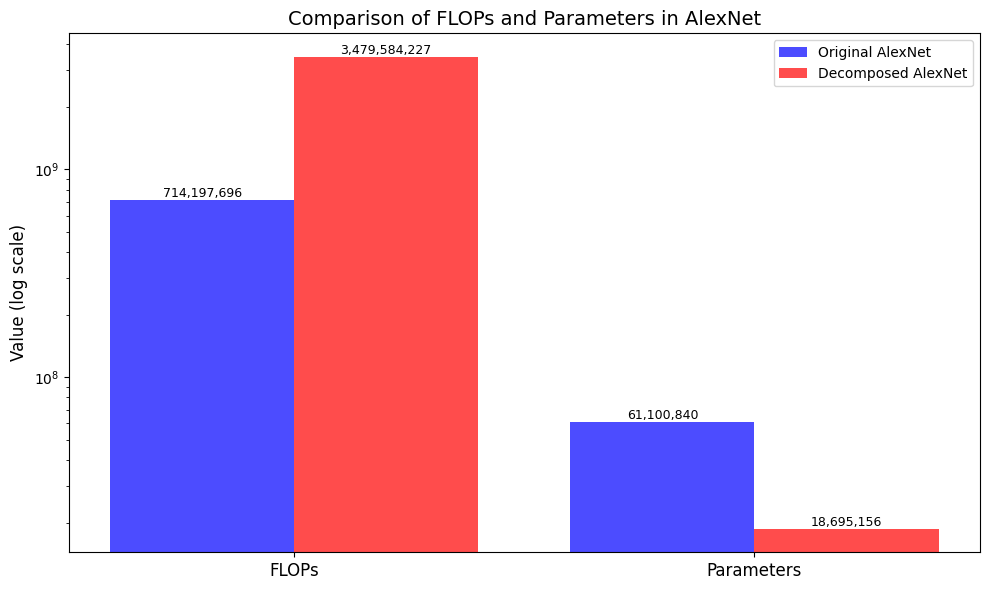

In [54]:
import matplotlib.pyplot as plt

# Metrics
labels = ['FLOPs', 'Parameters']
original_values = [714197696, 61100840]
decomposed_values = [3479584227, 18695156]

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Bar chart
x = range(len(labels))
plt.bar(x, original_values, width=0.4, label='Original AlexNet', align='center', color='blue', alpha=0.7)
plt.bar([p + 0.4 for p in x], decomposed_values, width=0.4, label='Decomposed AlexNet', align='center', color='red', alpha=0.7)

# Formatting
plt.xticks([p + 0.2 for p in x], labels, fontsize=12)
plt.yscale('log')  # Use log scale for clarity
plt.ylabel('Value (log scale)', fontsize=12)
plt.title('Comparison of FLOPs and Parameters in AlexNet', fontsize=14)
plt.legend(fontsize=10)

# Add value labels on top of each bar
for i, (orig, decomp) in enumerate(zip(original_values, decomposed_values)):
    plt.text(i, orig, f'{orig:,}', ha='center', va='bottom', fontsize=9)
    plt.text(i+0.4, decomp, f'{decomp:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()